# 1.6 Intro to NLP and Network Analysis

In [1]:
# importlibraries
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import os
import matplotlib.pyplot as plt
import scipy
import re

In [2]:
# Download English module

!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 5.6 MB/s eta 0:00:03
     -------------- ------------------------- 4.7/12.8 MB 12.4 MB/s eta 0:00:01
     ---------------------- ----------------- 7.3/12.8 MB 14.2 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 13.4 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 14.1 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# Load spacy English module
import spacy
NER = spacy.load("en_core_web_sm")

## Load Alice in Wonderland book

In [4]:
# load the book 

with open("alice_cleaned.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [38]:
# Optional: remove any leftover citations or strange characters
text = re.sub(r"\[\d+\]", "", text)  # [96], [23], etc.
text = re.sub(r"\s{2,}", " ", text)  # extra spaces
text = re.sub(r'“|”|"', '', text)    # fancy or double quotes
text = re.sub(r"’", "'", text)       # fancy apostrophes

print(text[:500])  # preview the cleaned output

Alices Adventures in Wonderland(also known asAlice in Wonderland) Englishchildrens novelbyLewis Carroll, a mathematicsdonat theUniversity of Oxford. It details the story of a girl namedAlicewho falls through a rabbit hole into a fantasy world ofanthropomorphiccreatures. It is seen as an example of theliterary nonsensegenre. The artist SirJohn Tennielprovided 42 wood-engraved illustrations for the book.
It received positive reviews upon release and is now one of the best-known works ofVictorian l


#### The text appears to be relatively clean. We might still want to:
####  -   Remove any extra whitespace or line breaks if present.
text = " ".join(text.split())  # Remove extra whitespace

####  Observations:
####  -   The text is in English.
####  -   It seems to be mostly clean, but we've removed extra whitespace.
####  -   No major inconsistencies in spelling that need correction.

## NER object

In [39]:
doc = nlp(text)

## Extract Sentence Entities

In [8]:
sentence_entities = []
for sent in doc.sents:
    entities = [(ent.text, ent.label_) for ent in sent.ents]
    sentence_entities.append({"sentence": sent.text, "entities": entities})

#  sentence_entities is now a list of dictionaries, each containing a sentence and its entities.

In [9]:
# Print the head (first 10) of sentence_entities
print(sentence_entities[:10]) 

[{'sentence': 'Alices Adventures in Wonderland(also known asAlice in Wonderland)', 'entities': [('Wonderland', 'GPE')]}, {'sentence': 'Englishchildrens novelbyLewis Carroll, a mathematicsdonat theUniversity of Oxford.', 'entities': [('Carroll', 'ORG'), ('theUniversity', 'GPE'), ('Oxford', 'GPE')]}, {'sentence': 'It details the story of a girl namedAlicewho falls through a rabbit hole into a fantasy world ofanthropomorphiccreatures.', 'entities': []}, {'sentence': 'It is seen as an example of theliterary nonsensegenre.', 'entities': []}, {'sentence': 'The artist SirJohn Tennielprovided 42 wood-engraved illustrations for the book.', 'entities': [('SirJohn Tennielprovided', 'ORG'), ('42', 'CARDINAL')]}, {'sentence': 'It received positive reviews upon release and is now one of the best-known works ofVictorian literature; its narrative, structure, characters and imagery have had a widespread influence on popular culture and literature, especially in thefantasygenre.', 'entities': [('ofVicto

## Load Countries

In [20]:
countries = [
    "France", "Germany", "India", "Pakistan", "England", "China", "Russia", 
    "United Kingdom", "United States", "Australia", "Japan", "Italy", "Spain"
]

##  Store in DataFrame and Filter

In [37]:
df_entities = pd.DataFrame(sentence_entities)

# Optional: save raw entity dataframe
df_entities.to_csv("sentence_entities.csv", index=False)

# Load country list
countries = ['India', 'China', 'France', 'Germany', 'USA', 'Russia', 'Italy', 'Japan', 'Spain', 'England', 'Pakistan']

# Filter only relevant entities
def filter_to_countries(entity_list):
    return [e for e in entity_list if e in countries]

df_entities["filtered"] = df_entities["entities"].apply(filter_to_countries)

# Preview
df_entities[df_entities["filtered"].apply(lambda x: len(x) > 0)].head() 

,sentence,entities,filtered
163,",Alice in Wonderlandwas named among the icons ...","[Wonderlandwas, England]",[England]
170,A popular figure in Japan sincethe country ope...,[Japan],[Japan]
193,"Although the original production inHamburg, Ge...",[Germany],[Germany]
195,It was performed frequently in England and the...,[England],[England]
198,"Gerald Barry one-actopera,Alices Adventures Un...",[France],[France]


## Create Relationship Pairs

In [40]:
relationships = []
window_size = 5

for i in range(df_sentences_filtered.index[-1]):
    end_i = min(i + window_size, df_sentences_filtered.index[-1])
    
    countries_window = sum((df_sentences_filtered.loc[i:end_i, "country_entities"]), [])
    
    unique_countries = [countries_window[j] for j in range(len(countries_window))
                        if j == 0 or countries_window[j] != countries_window[j - 1]]

    if len(unique_countries) > 1:
        for idx in range(len(unique_countries) - 1):
            relationships.append({
                "source": unique_countries[idx],
                "target": unique_countries[idx + 1]
            })

relationships_df = pd.DataFrame(relationships)

# Show results
relationships_df.head(10)


,source,target
0,Germany,France
1,France,Australia
2,France,Australia
3,Australia,UK
4,France,Australia
5,Australia,UK
6,Australia,UK
7,Australia,UK
8,Australia,UK
9,Germany,United States


## Add Value

In [34]:
# Add a column for value (weight of connection)
df_relationships["value"] = 1

# Group by source and target to count frequency of relationships
df_relationships = df_relationships.groupby(["Source", "Target"], sort=False, as_index=False).sum()

# Preview top rows
df_relationships.head()

,Source,Target,value
0,Germany,France,1
1,Germany,Japan,1
2,Germany,Spain,1
3,France,Japan,1
4,France,Spain,1


In [41]:
# Save the relationships dataframe to CSV
relationships_df.to_csv("country_relationships.csv", index=False)


## Frequency check

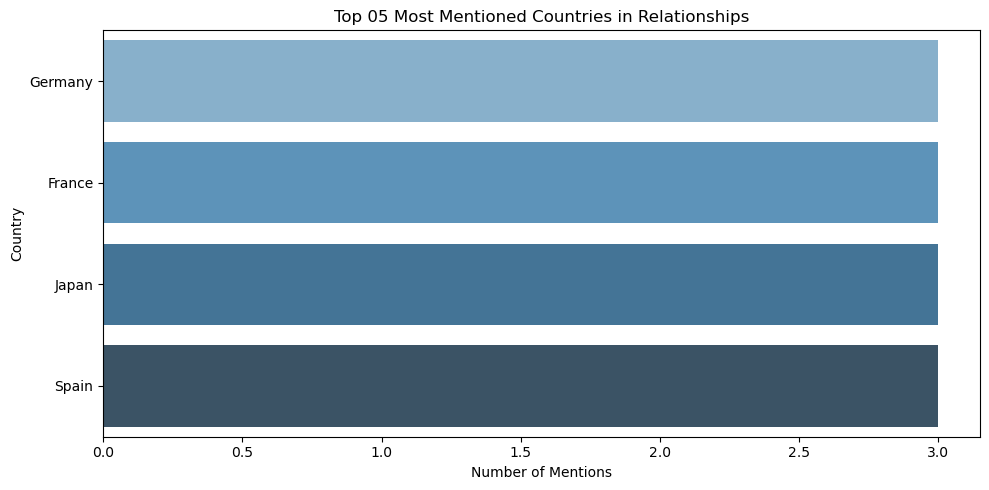

In [45]:
# Combine Source and Target columns to get overall country mentions
country_mentions = df_relationships["Source"].tolist() + df_relationships["Target"].tolist()
country_counts = pd.Series(country_mentions).value_counts().head(10)

# Plot with proper hue assignment to avoid future warning
plt.figure(figsize=(10, 5))
sns.barplot(
    x=country_counts.values,
    y=country_counts.index,
    hue=country_counts.index,        # Assign hue as required
    palette="Blues_d",
    dodge=False                      # Disable hue splitting
)
plt.xlabel("Number of Mentions")
plt.ylabel("Country")
plt.title("Top 05 Most Mentioned Countries in Relationships")
plt.legend([],[], frameon=False)     # Hide the legend
plt.tight_layout()
plt.show()